In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from error_propagation import Complex
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry
from photutils.psf import make_psf_model_image, CircularGaussianPSF, GaussianPSF, MoffatPSF
from tqdm import tqdm
import emcee
norm = ImageNormalize(stretch=SqrtStretch())

# Galfic Plotting Code
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

# Glafic Tabular 

# Read_script.py
# Open the Python file as a text file
def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
    with open(filename_0, 'r') as file:
        # Read the contents of the file
        content = file.read()
        file.close()
    
    with open(filename_6, 'r') as file:
        content_opt = file.read()
        file.close()

    # Define a function to find a line in the file
    def find_line(word, content):
        content = content.split('\n')
        line_number = 0
        for line in content:
            line_number += 1
            if word in line:
                return line_number
        return "Line Not Found"
    
    def find_last_line(word, content):
        content = content.split('\n')
        line_number = 0
        last_occurrence = -1
        for line in content:
            line_number += 1
            if word in line:
                last_occurrence = line_number
        return last_occurrence

    # Set lens line number
    line_set_1 = find_line('glafic.set_lens(1,', content)
    line_opt_1 = find_line('glafic.setopt_lens(1,', content)

    if shear == True:
        line_set_2 = find_line('glafic.set_lens(2,', content)
        line_opt_2 = find_line('glafic.setopt_lens(2,', content)

    # Split the content by new line
    content_list = content.split('\n')

    # Get the set_lens line
    set_lens_1 = content_list[line_set_1-1]

    # Get the setopt_lens line
    setopt_lens_1 = content_list[line_opt_1-1]

    # Define the list of possible models
    models = ['SIE', 'POW', 'NFW', 'EIN']

    parts_set_lens = set_lens_1.split(',')
    parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

    parts_setopt_lens = setopt_lens_1.split(',')
    parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


    if shear == True:
    # Get the shear set_lens line
        set_lens_2 = content_list[line_set_2-1]

        # Get the shear setopt_lens line
        setopt_lens_2 = content_list[line_opt_2-1]

        parts_set_lens_2 = set_lens_2.split(',')
        parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

        parts_setopt_lens_2 = setopt_lens_2.split(',')
        parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

        if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
            raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

        if 'pert' in set_lens_2:
            name = 'Shear'
            z_s = parts_set_lens_2[3]
            x = parts_set_lens_2[4]
            y = parts_set_lens_2[5]
            gamma = parts_set_lens_2[6]
            pa = parts_set_lens_2[7]
            NaN = parts_set_lens_2[8]
            pwi = parts_set_lens_2[9].replace(')', '') 

            z_s_flag = parts_setopt_lens_2[2]
            x_flag = parts_setopt_lens_2[3]
            y_flag = parts_setopt_lens_2[4]
            gamma_flag = parts_setopt_lens_2[5]
            pa_flag = parts_setopt_lens_2[6]
            NaN_flag = parts_setopt_lens_2[7]
            pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

            line = find_last_line('lens   pert', content_opt)
            line_content = content_opt.split('\n')[line - 1]
            line_list = line_content.split()

            row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
            row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
            row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
            row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

            table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            if show_shear:
                print(table_shear)

            if save_table_flag:
                table_shear.to_csv('shear_table.csv')
        return table_shear

    if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
        raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
    for i in models:
        i = i.lower()
        if i in set_lens_1:
            if i == models[1].lower(): # POW model
                name = models[1]
                z_s = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_ein = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                z_s_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_ein_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   pow', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
                row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[0].lower(): # SIE model
                name = models[0]
                sigma = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_core = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                sigma_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_core_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   sie', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
                row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[2].lower(): # NFW model    
                name = models[2]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                c = parts_set_lens[8]
                Nan = parts_set_lens[9].replace(')', '') 

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                c_flag = parts_setopt_lens[7]
                Nan_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   anfw', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
                row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            elif i == models[3].lower(): # EIN model
                name = models[3]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                ce_rs = parts_set_lens[8]
                alpha_e = parts_set_lens[9].replace(')', '')

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                ce_rs_flag = parts_setopt_lens[7]
                alpha_e_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   ein', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', '$α_{e}$']
                row_1 = ['Input Value', m, x, y, e, pa, ce_rs, alpha_e]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, ce_rs_flag, alpha_e_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            
            if show_params:
                print(table)

            if save_table_flag:
                table.to_csv('table.csv')
            
            return table, chi_list

    print("Model not found")
    return None  # Explicitly return None if no model is found



# Position and Magnification Plots

def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, title, 
               table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
    
    if table_flag:
        if glafic_file_1 is None:
            print("Please provide the filename for the glafic script")
            raise ValueError("Glafic File not provided")
        elif glafic_file_2 is None:
            print("Please provide the Opt Result filename for the glafic script")
            raise ValueError("Glafic File not provided")

    if table_flag:    
        table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
        if table is None:
            raise ValueError("Failed to create the table from the glafic file.")

    if shear:
        table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
        if table_shear is None:
            raise ValueError("Failed to create the table from the glafic file.")
        
    # Storage for parsed data
    data = []
    
    # val = pd.read_csv(filename_4)
    # val.__dataframe__
    # val_column = val.columns[0]

    # # Split the values in the data_column and expand into separate columns
    # val = val[val_column].str.split(expand=True)

    # # Convert the DataFrame to numeric type
    # val = val.apply(pd.to_numeric)

    # print(val)

    with open(filename_2, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    val = pd.DataFrame(data)
    val = val.iloc[1:]
    brightest_flux = max(val[2])
    brightest_index = val[2].idxmax()

    # Add a column called 'colour' to val
    val['colour'] = ''

    # Assign 'red' to the brightest image
    val.at[brightest_index, 'colour'] = 'red'

    # Get the coordinates of the brightest image
    brightest_x = val.at[brightest_index, 0]
    brightest_y = val.at[brightest_index, 1]

    # Calculate the angles of the other images relative to the brightest image
    angles = np.arctan2(val[1] - brightest_y, val[0] - brightest_x)

    # Sort the indices of the images by angle in clockwise order
    sorted_indices = angles.sort_values(ascending=False).index

    # Assign colours to the remaining images
    colours = ['green', 'yellow', 'blue']
    colour_index = 0
    for idx in sorted_indices:
        if val.at[idx, 'colour'] == '':
            val.at[idx, 'colour'] = colours[colour_index]
            colour_index += 1
    
    val['flux_ratio'] = abs(val[2] / brightest_flux)

    err_1 = Complex(val[2][1], val[4][1])
    err_2 = Complex(val[2][2], val[4][2])
    err_3 = Complex(val[2][3], val[4][3])
    err_4 = Complex(val[2][4], val[4][4])

    ratio_1 = str(Complex.truediv(err_1, err_2))
    ratio_2 = str(Complex.truediv(err_2, err_2))
    ratio_3 = str(Complex.truediv(err_3, err_2))
    ratio_4 = str(Complex.truediv(err_4, err_2))

    ratio_1_error = float(ratio_1.split(' ± ')[1])
    ratio_2_error = float(ratio_2.split(' ± ')[1])
    ratio_3_error = float(ratio_3.split(' ± ')[1])
    ratio_4_error = float(ratio_4.split(' ± ')[1])

    val['flux_ratio_error'] = [ratio_1_error, ratio_2_error, ratio_3_error, ratio_4_error]

    data = []

    # Line by line read (Remove # from obs file)
    with open(filename_1, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    # Convert to DataFrame
    data_df = pd.DataFrame(data)

    # Exclude the first row
    data_df = data_df.iloc[1:]
    
    data_df.insert(8, "Label", val['colour'].map({'red': 'Red Image', 'green': 'Green Image', 'yellow': 'Yellow Image', 'blue': 'Blue Image'}), True)

    # Reorder the images according to the order red, green, yellow, blue
    order = ['Red Image', 'Green Image', 'Yellow Image', 'Blue Image']
    data_df['Label'] = pd.Categorical(data_df['Label'], categories=order, ordered=True)
    data_df = data_df.sort_values('Label').reset_index(drop=True)

    data_df = data_df.drop(columns =[3, 5, 6, 7])

    # Read and process the predicted data
    data_pred = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    df_pred = data_pred.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            df_pred = swap_rows(df_pred, i, (m-1))
        else:
            continue

    df_pred = df_pred.drop(columns =[3])

    # Eliminating the 5th image
    if len(df_pred[2])>num_images:
        i = len(df_pred[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(df_pred[2]))
            df_2 = abs(df_pred)
            b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
            df_3 = df_pred.drop((b+1), axis='index')
            df_pred = df_3
            df_pred.reset_index(drop=True, inplace=True)
        df_pred.index = df_pred.index + 1

    df_pred = df_pred.reset_index(drop=True)

    # Calculations for Position Error values
    d_x = (abs(data_df[0]) - abs(df_pred[0])).abs()
    d_y = (abs(data_df[1]) - abs(df_pred[1])).abs()
    sum_sq = (d_x**2) + (d_y**2)
    sq = np.sqrt(sum_sq)
    rms = np.average(sq)
    rms_unit = rms*1000
    rms_round = round(rms_unit, 3)/1000
    rms_str = str(rms_round)

    # Plotting Position Error Graph
    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    colours1 = ['lightsalmon', 'green', 'gold', 'blue']
    plt.figure(figsize=(15, 5), dpi=500)
    plt.subplot(1, 3, 1)
    plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
    plt.axhline(xmin=0.045, xmax=0.13, y=1.28/1000, linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
    plt.axhline(xmin=0.32, xmax=0.40, y=0.85/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.6, xmax=0.68, y=0.83/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.87, xmax=0.95, y=0.39/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.title('Position Diagnostic (ΔRMS = ' + rms_str + ')', fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.xticks(fontsize=8)
    plt.ylim(0, max(sq)+0.005)
    plt.xlabel('Images')
    plt.ylabel('Positional offset')

    # Calculations for Magnification value
    # Previous Code: f = df_pred[2][1]
    max_flux = max(abs(df_pred[2]))
    flux_ratio = df_pred[2]/max_flux
    df_pred[3] = abs(flux_ratio)

    # Create data 
    x = np.arange(4)
    width = 0.3

    # FITS image processing for predicted flux at observed positions 
    image = fits.open(filename_5)
    values = 1/image[0].data
    image.close()
    dat = values[6]
    g = (data_df[0]/0.01).astype(int) - 2000
    h = (data_df[1]/0.01).astype(int) - 2000

    g_max = (g + 1).astype(int)
    h_max = (h + 1).astype(int)
    g_min = (g - 1).astype(int)
    h_min = (h - 1).astype(int)


    flux_pos = []
    flux_pos_max = []
    flux_pos_min = []

    for i in range(0,4):
        flux_cal = dat[h[i]][g[i]]
        flux_pos.append(abs(flux_cal))
    

    for i in range(0,4):
        flux_cal_max = dat[h_max[i]][g_max[i]]
        flux_pos_max.append(abs(flux_cal_max))

    
    for i in range(0,4):
        flux_cal_min = dat[h_min[i]][g_min[i]]
        flux_pos_min.append(abs(flux_cal_min))
    
    arrow_legnths = (np.array(flux_pos_max) - np.array(flux_pos_min))/100
    # arrow_legnths = [0,0,0,0]
    true_flux = np.array(flux_pos)

    # Switch columns of val according to the previous colour indexing
    val = val.set_index('colour').loc[['red', 'green', 'yellow', 'blue']].reset_index()

    height = max(val[2]) + 5
    # Plotting Flux Error Graph
    plt.subplot(1, 3, 2)
    plt.bar(x+0.15, val[2], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
    plt.bar(x-0.15, abs(df_pred[2]), width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
    plt.bar(x+0.45, true_flux, width, color='orange', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
    # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
    plt.errorbar(x+0.15, val[2], yerr=val[4], fmt='.', color='black', capsize=5, label='1 σ Error')
    plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
    plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.4, fc='k', ec='k')
    plt.xlabel("Images") 
    plt.ylabel("Magnifications") 
    plt.ylim()
    plt.legend(loc = 'upper right', fontsize='small')
    plt.title('Magnification Diagnostic', fontsize=10)
    plt.suptitle(title)
    if table_flag:
        table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
        table_plot.auto_set_font_size(False)
        table_plot.set_fontsize(10)
        plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
        if shear == True:
            table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
            table_shear_plot.auto_set_font_size(False)
            table_shear_plot.set_fontsize(10)

    return data_df, df_pred



# Critical Curves Plot

def critcurve_plot(filename_4, filename_3, pos_output, num_images):
    data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
    data_crit.__dataframe__
    df = data_crit.iloc[1:]

    obs = pd.DataFrame(pos_output)

    # Initialize empty list 
    data = []

    # Read and process the predicted data
    de = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    de = de.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(obs.iloc[i,0]) - abs(de[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            de = swap_rows(de, i, (m-1))
        else:
            continue

        
    de = de.drop(columns =[3])

    # Eliminating the 5th image
    if len(de[2])>num_images:
        i = len(de[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(de[2]))
            df_4 = abs(de)
            b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
            df_5 = de.drop((b+1), axis='index')
            de = df_5
            de.reset_index(drop=True, inplace=True)
        de.index = de.index + 1

    labels = ['A', 'B', 'C', 'D']

    # Plotting Critial Curves
    plt.subplot(1, 3, 3)
    plt.scatter(df[0]/0.04, df[1]/0.04, s=2, color = 'orange', label = 'Critical Curve')
    plt.scatter(df[2]/0.04, df[3]/0.04, s=2)
    plt.scatter(df[4]/0.04, df[5]/0.04, s=2)
    plt.scatter(df[6]/0.04, df[7]/0.04, s=2, label = 'Caustics')

    height_1 = max(df[0]/0.04)
    height_2 = max(df[1]/0.04)

    # colors = ['red',  'blue', 'green', 'gold']
    colors = obs['Label'].map({'Red Image': 'red', 'Green Image': 'green', 'Yellow Image': 'gold', 'Blue Image': 'blue'}).tolist()

    # Plotting obs image positions and labels 
    plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', color = colors, alpha = 0.5, label = 'Predicted Position')
    plt.scatter(obs[0]/0.04, obs[1]/0.04, s=15, color = colors, marker = 'o', label = 'Observed Position')
    # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
    #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

    plt.title('Critical Curves and Caustics', fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.tick_params(labelsize=8)
    plt.xlabel('x [Pixel]')
    plt.ylabel('y [Pixel]', labelpad=0)
    # Calculate the natural limits of the graph
    x_min, x_max = min(df[0]/0.04), max(df[0]/0.04)
    y_min, y_max = min(df[1]/0.04), max(df[1]/0.04)

    # Define a zoom factor
    zoom_factor = 0.2

    # Calculate the limits with the zoom factor
    x_range = (x_max - x_min) * zoom_factor
    y_range = (y_max - y_min) * zoom_factor

    plt.xlim(x_min - x_range, x_max + x_range)
    plt.ylim(y_min - y_range, y_max + y_range)

    plt.show()


    
    return df

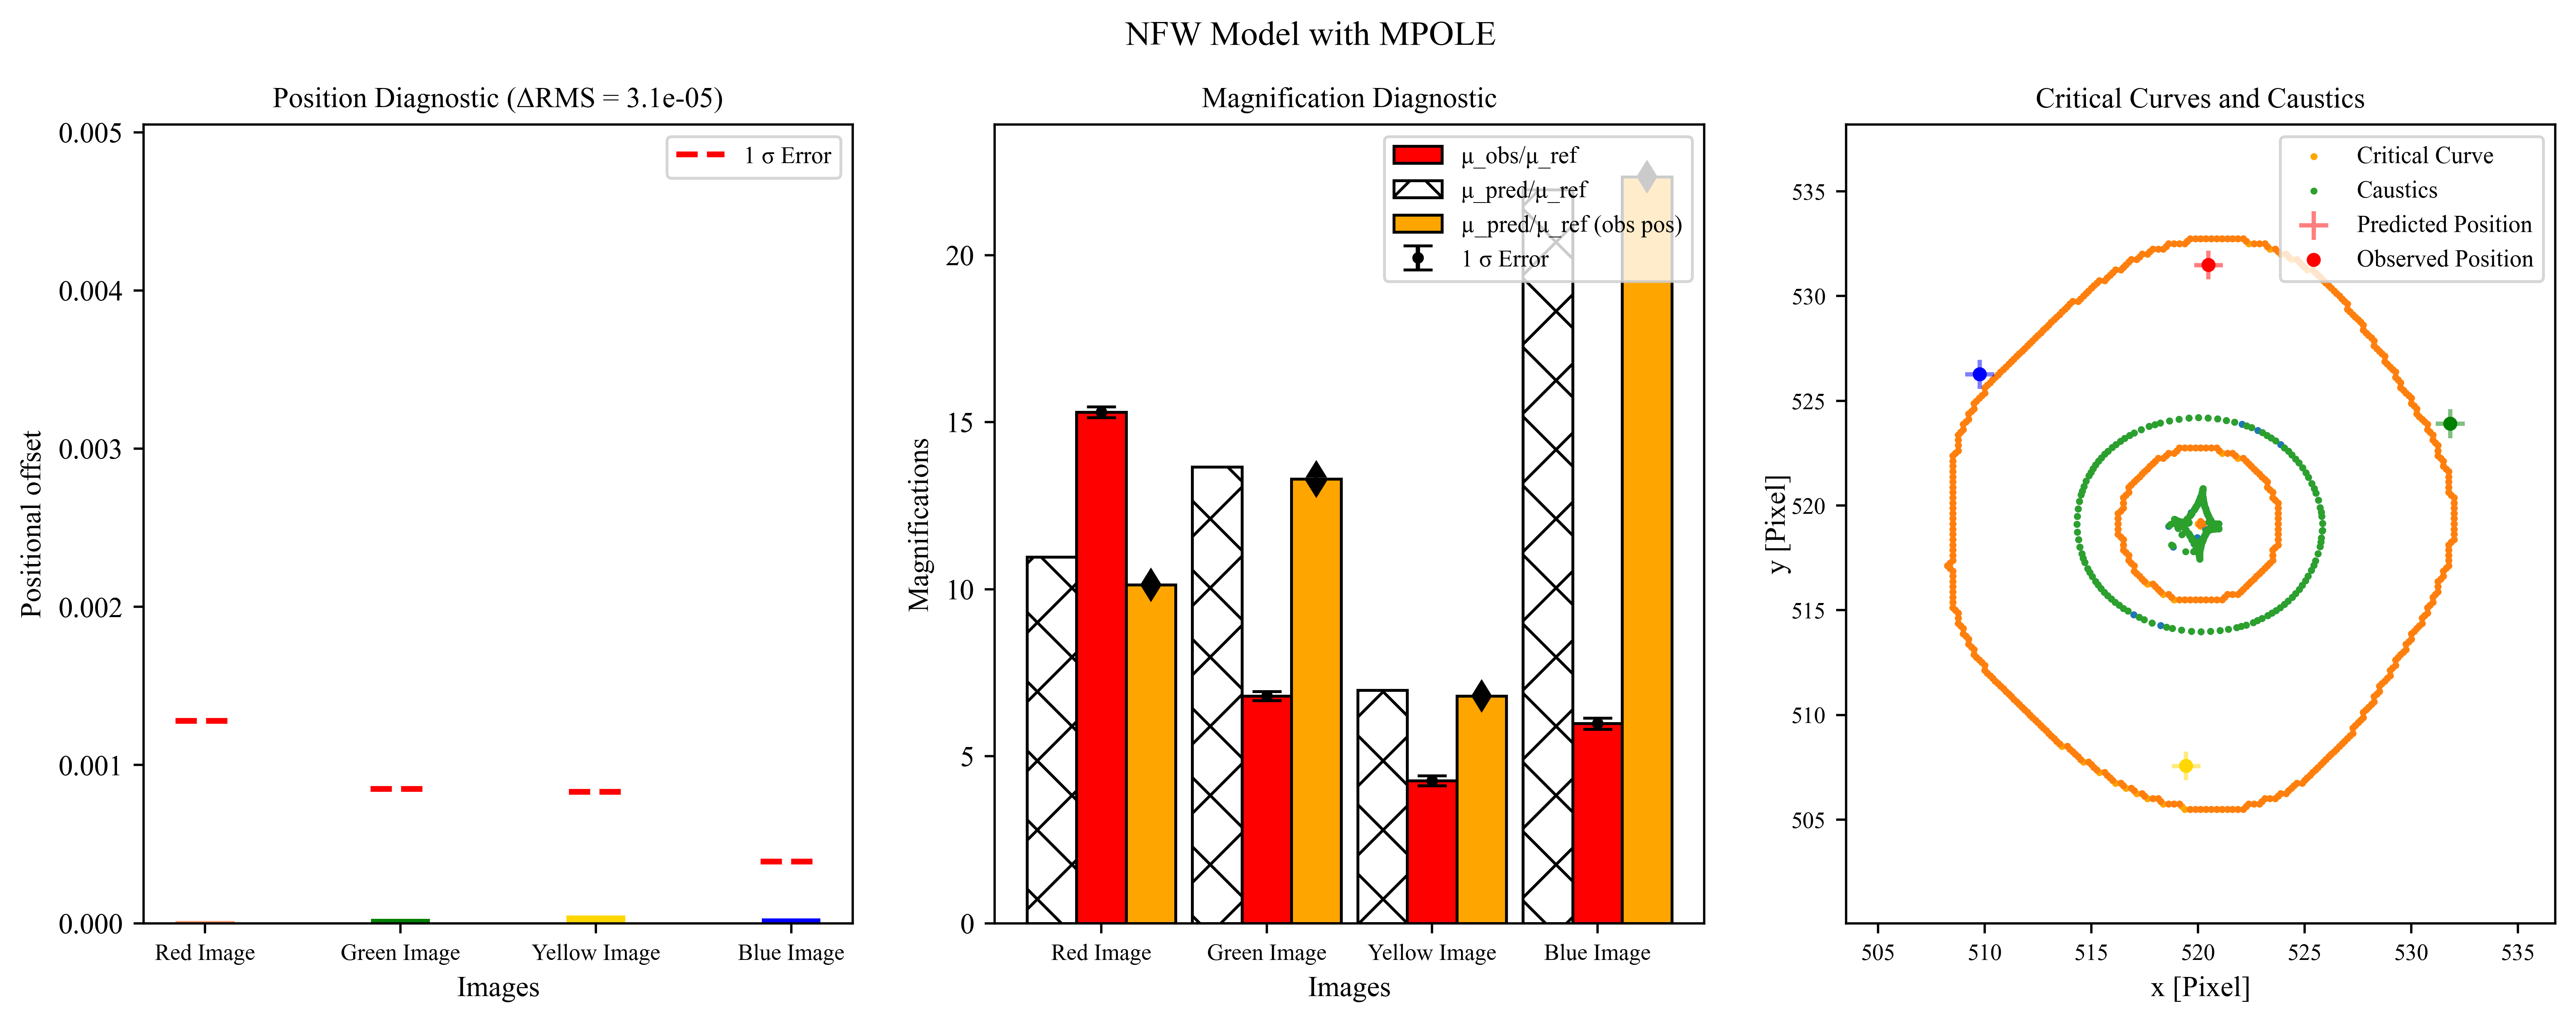

In [34]:
plot_name_1 = 'NFW_POS_MPOLE'
loc = 'NFW+MPOLE/'
title = 'NFW Model with MPOLE'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point_SIE(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, title, table_flag=False, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)